# Forecasting of Gold Prices

## Objectives:
    
    1. Understand underlying structure of the dataset.
    2. Build a suitable forecasting model for the given gold data.
    3. Predict gold prices for the next `30` days.
    
## Data information:

This data is received from ExcelR institute.
The dataset contains 2 columns:
* Date (2016-01-01 to 2021-12-21)
* Price

In [66]:
# Importing important libraries...

import pandas as pd
import numpy as np
from datetime import datetime, time
import matplotlib.pyplot as plt
import seaborn as sns

!pip install statsmodels
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

!pip install pmdarima
import pmdarima as pm

In [67]:
print(statsmodels.__version__)

0.13.2


In [64]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.statespace.sarimax import SARIMAX

### 1. Understanding the dataset

In [3]:
# Import dataset 

gold_data = pd.read_csv("data/Gold_data.csv")
gold_data

,date,price
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75
...,...,...
2177,2021-12-17,4394.40
2178,2021-12-18,4389.50
2179,2021-12-19,4389.50
2180,2021-12-20,4354.10


In [4]:
# Checking for null values and data types

gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2182 non-null   object 
 1   price   2182 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.2+ KB


In [5]:
# Converting 'date' from `object` dtype to `datetime` dtype

gold_data["date"] = pd.to_datetime(gold_data["date"])
gold_data

,date,price
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75
...,...,...
2177,2021-12-17,4394.40
2178,2021-12-18,4389.50
2179,2021-12-19,4389.50
2180,2021-12-20,4354.10


In [6]:
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2182 non-null   datetime64[ns]
 1   price   2182 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 34.2 KB


In [7]:
gold_data.shape, len(gold_data)

((2182, 2), 2182)

In [8]:
2182 / 364     # Days in a year.

5.9945054945054945

In [9]:
# # Adding 'year', 'month' and 'day' column to the dataset...

# gold_data['year'] = pd.DatetimeIndex(gold_data['date']).year
# gold_data['month'] = pd.DatetimeIndex(gold_data['date']).month
# gold_data["day"] = pd.DatetimeIndex(gold_data['date']).day
# gold_data

### Exploratory Data Analysis (EDA)

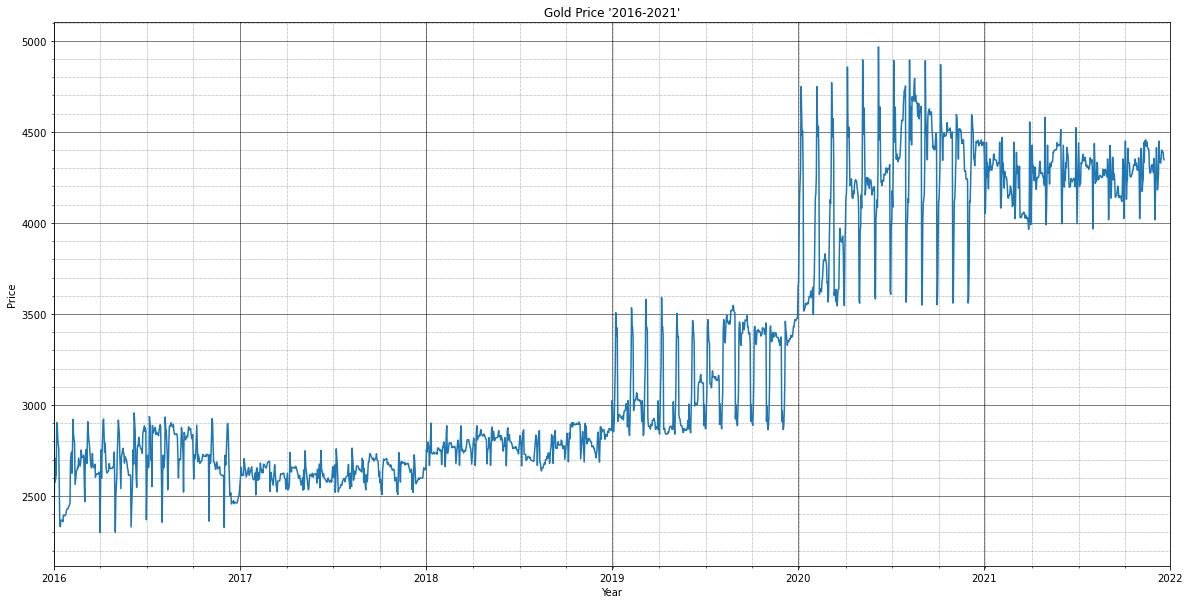

In [10]:
# Plotting lineplot of "day" and "price"

fig, ax = plt.subplots(figsize= (20,10))

sns.lineplot(data= gold_data, x= "date", y= "price")

ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=0.5, color='black',)
ax.grid(which='minor', linestyle=':', linewidth=0.5, color='black', alpha=0.7)

ax.set(title = "Gold Price '2016-2021'",
      xlabel = "Year",
      ylabel = "Price");
ax.set_xlim([datetime(2016,1,1), datetime(2022,1,1)]);

In [11]:
# Resampling gold_data with mean() of 'year' , 'month' and 'quarter'

data_resample_y = gold_data.resample(rule='Y', on='date').mean()
data_resample_m = gold_data.resample(rule='M', on='date').mean()
data_resample_q = gold_data.resample(rule='Q', on='date').mean()

In [12]:
data_resample_q["price"]

date
2016-03-31    2621.007692
2016-06-30    2700.096154
2016-09-30    2788.126630
2016-12-31    2652.572645
2017-03-31    2622.654630
2017-06-30    2611.393407
2017-09-30    2636.719022
2017-12-31    2635.685326
2018-03-31    2760.522222
2018-06-30    2798.379670
2018-09-30    2745.982065
2018-12-31    2822.581522
2019-03-31    3023.345556
2019-06-30    3015.557143
2019-09-30    3266.105435
2019-12-31    3291.613043
2020-03-31    3873.320879
2020-06-30    4215.295604
2020-09-30    4428.619565
2020-12-31    4344.538043
2021-03-31    4210.840000
2021-06-30    4290.093407
2021-09-30    4260.927174
2021-12-31    4309.268293
Freq: Q-DEC, Name: price, dtype: float64

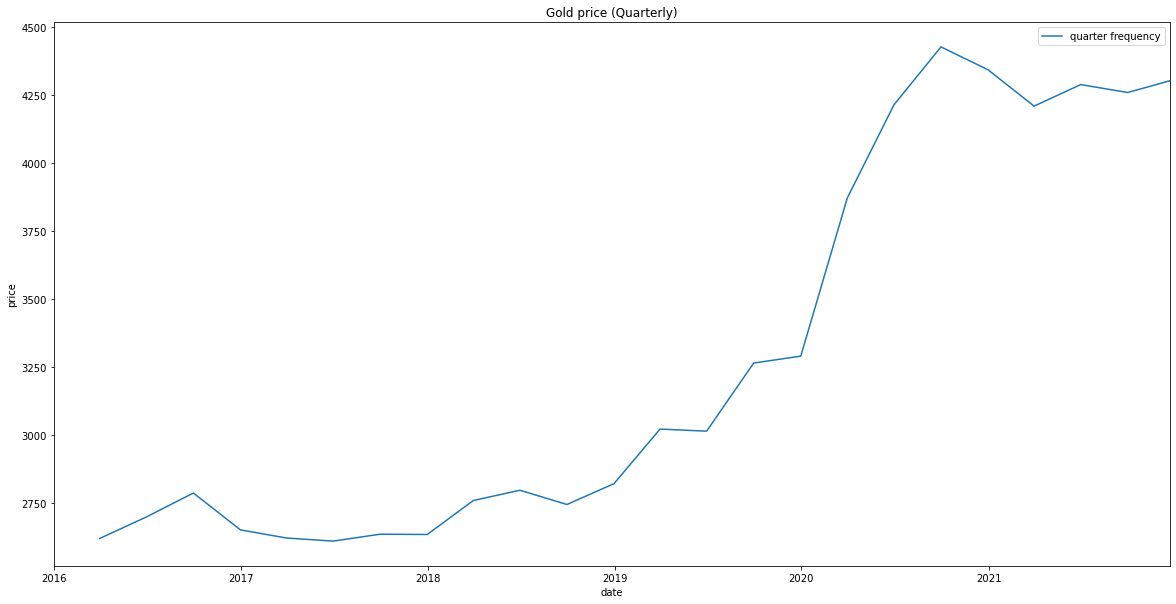

In [13]:
# Lineplot for `months` = 'Quarterly'

f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=data_resample_q, x="date", y="price", label="quarter frequency")
ax.set(title = "Gold price (Quarterly)")
ax.set_xlim([datetime(2016,1,1), datetime(2021,12,21)]);

In [14]:
data_resample_y["price"]

date
2016-12-31    2690.614162
2017-12-31    2626.676484
2018-12-31    2781.938082
2019-12-31    3150.210685
2020-12-31    4216.378689
2021-12-31    4266.871549
Freq: A-DEC, Name: price, dtype: float64

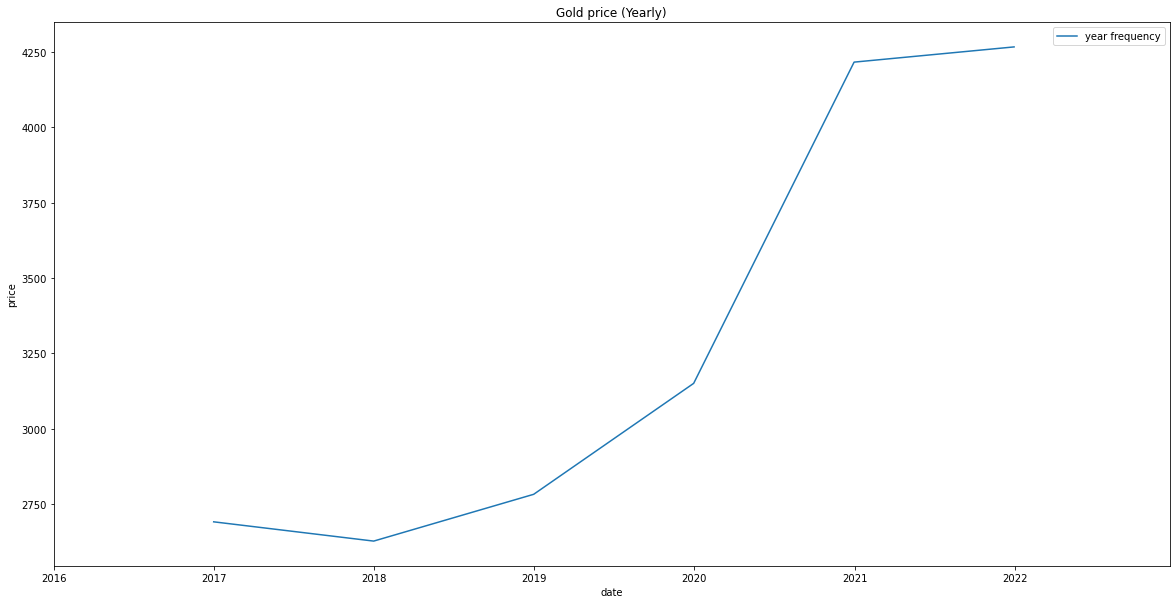

In [15]:
# Lineplot for `months` = 'Yearly'

f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=data_resample_y, x="date", y="price", label="year frequency")
ax.set(title = "Gold price (Yearly)")
ax.set_xlim([datetime(2016,1,1), datetime(2022,12,21)]);

In [16]:
data_resample_m["price"]

date
2016-01-31    2495.832258
2016-02-29    2688.703448
2016-03-31    2682.854839
2016-04-30    2677.790000
2016-05-31    2677.650000
                 ...     
2021-08-31    4264.919355
2021-09-30    4207.506667
2021-10-31    4289.148387
2021-11-30    4327.633333
2021-12-31    4312.733333
Freq: M, Name: price, Length: 72, dtype: float64

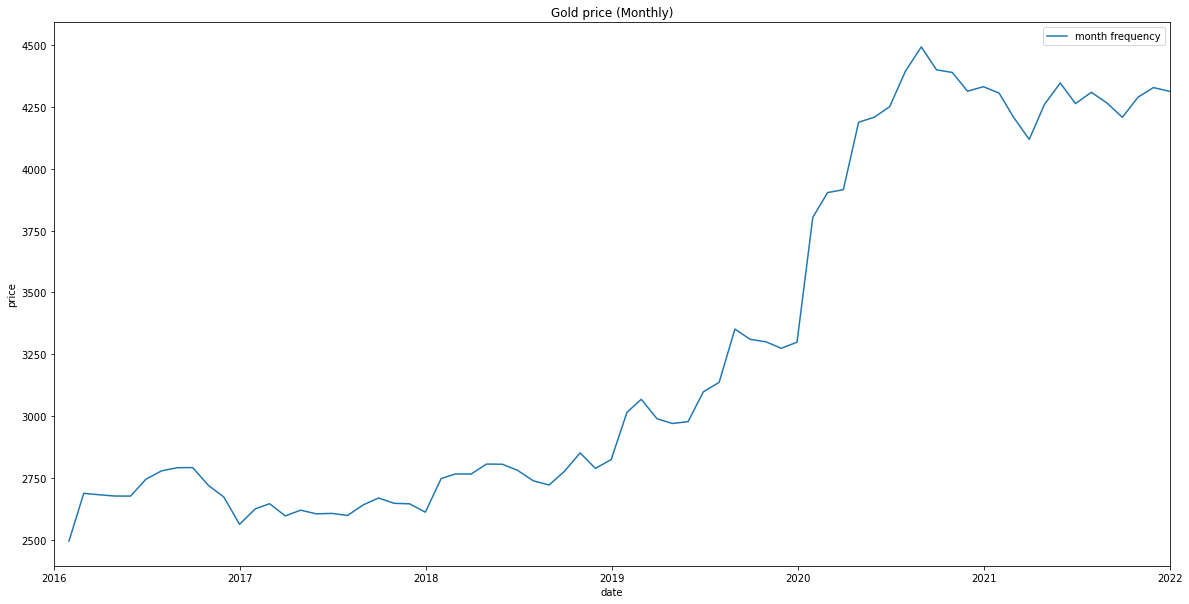

In [17]:
# Lineplot for `months` = 'Monthly'

f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=data_resample_m, x="date", y="price", label="month frequency");
ax.set(title = "Gold price (Monthly)")
ax.set_xlim([datetime(2016,1,1), datetime(2022,1,1)]);

In [18]:
# Check on "price"

gold_data["price"].describe()

count    2182.000000
mean     3284.450046
std       719.564434
min      2252.600000
25%      2697.020000
50%      2879.800000
75%      4147.325000
max      4966.300000
Name: price, dtype: float64

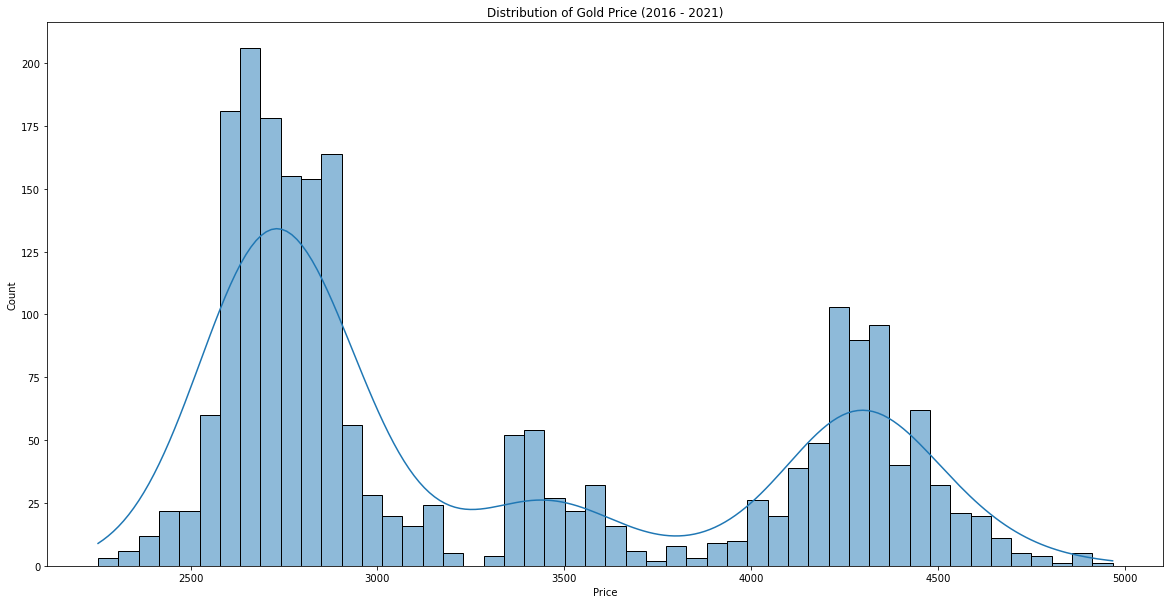

In [19]:
# Histogram for 'price' to check it's distribtion

fig = plt.figure(figsize = (20, 10))
sns.histplot(gold_data["price"], bins=50, kde=True)
plt.title("Distribution of Gold Price (2016 - 2021)")
plt.xlabel("Price")
plt.ylabel("Count");

In [20]:
# Making 'date' column as index of the dataset

gold_data_2 = gold_data.copy()
gold_data_2.set_index("date", inplace = True)
# gold_data_2.drop(["year", "month", "day"], axis = 1, inplace = True)
gold_data_2.head()

,price
date,
2016-01-01,2252.60
2016-01-02,2454.50
2016-01-03,2708.10
2016-01-04,2577.80
2016-01-05,2597.75


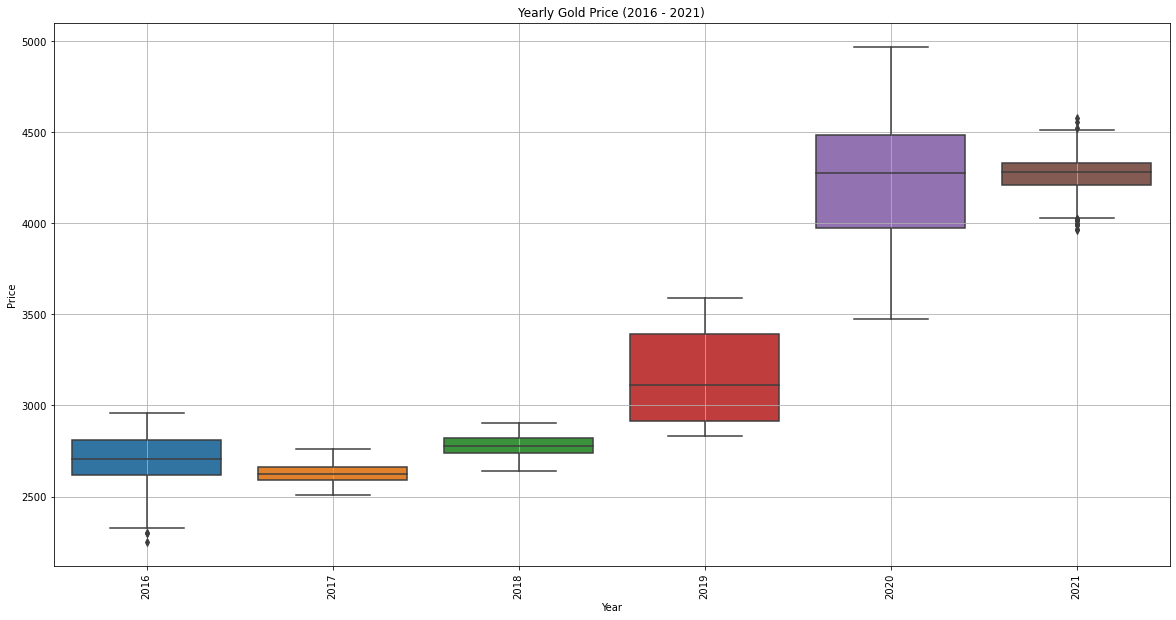

In [21]:
# Boxplot for Yearly Gold Price

_, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x = gold_data_2.index.year ,y = gold_data_2.price, ax=ax)
plt.title("Yearly Gold Price (2016 - 2021)")
plt.xlabel("Year")
plt.ylabel("Price")
plt.xticks(rotation=90)
plt.grid();

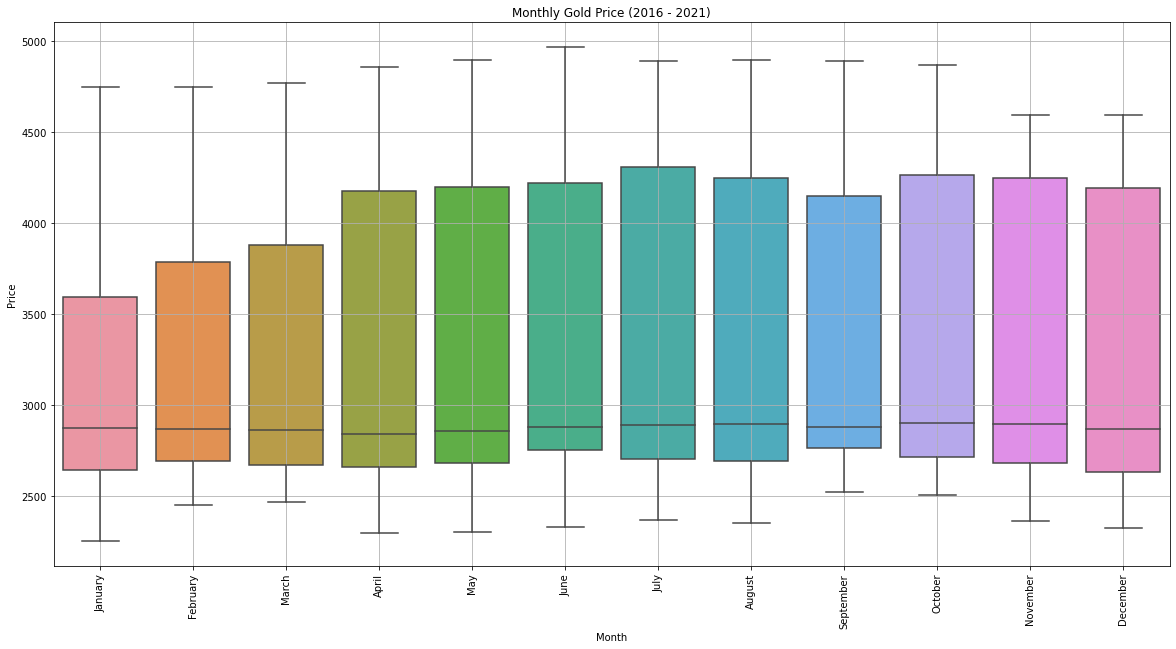

In [22]:
# Boxplot for Monthly GOld Price

_, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x= gold_data_2.index.month_name() , y= gold_data_2.price, ax=ax)
plt.title("Monthly Gold Price (2016 - 2021)")
plt.xlabel("Month")
plt.ylabel("Price")
plt.xticks(rotation=90)
plt.grid();

#### Trend , Seasonality & Redisual plots

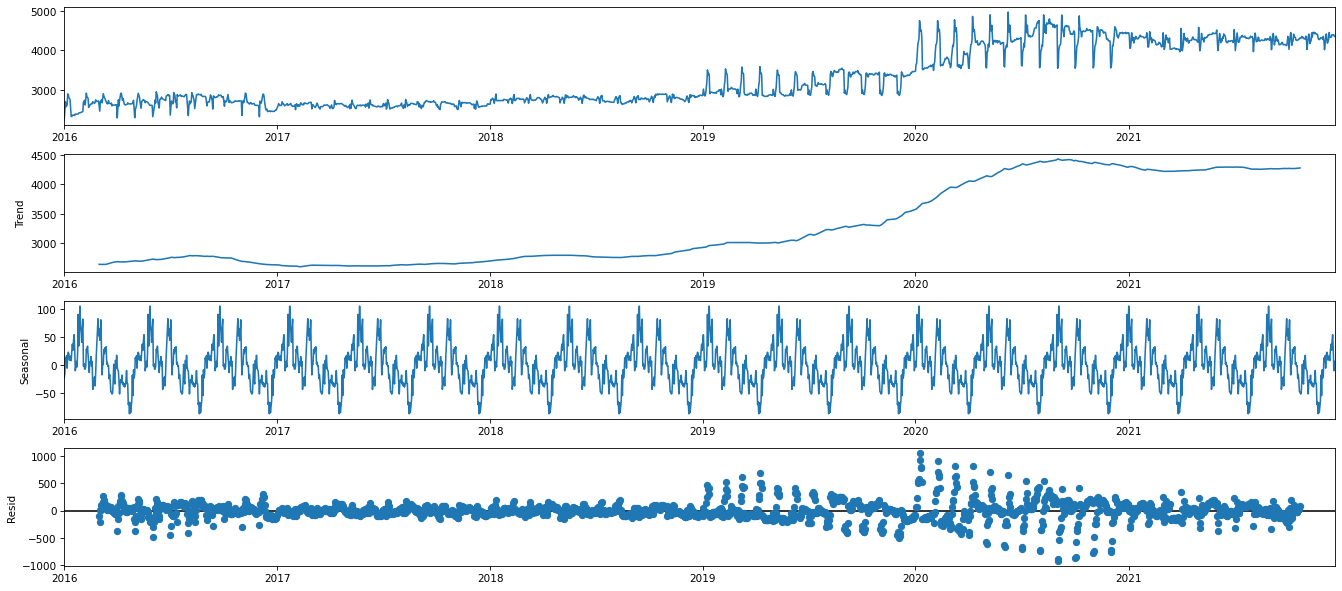

In [23]:
# Seasonal decompose plot for year 2016 - 2021

plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
result = seasonal_decompose(gold_data_2, model='additive', period=120)
result.plot();

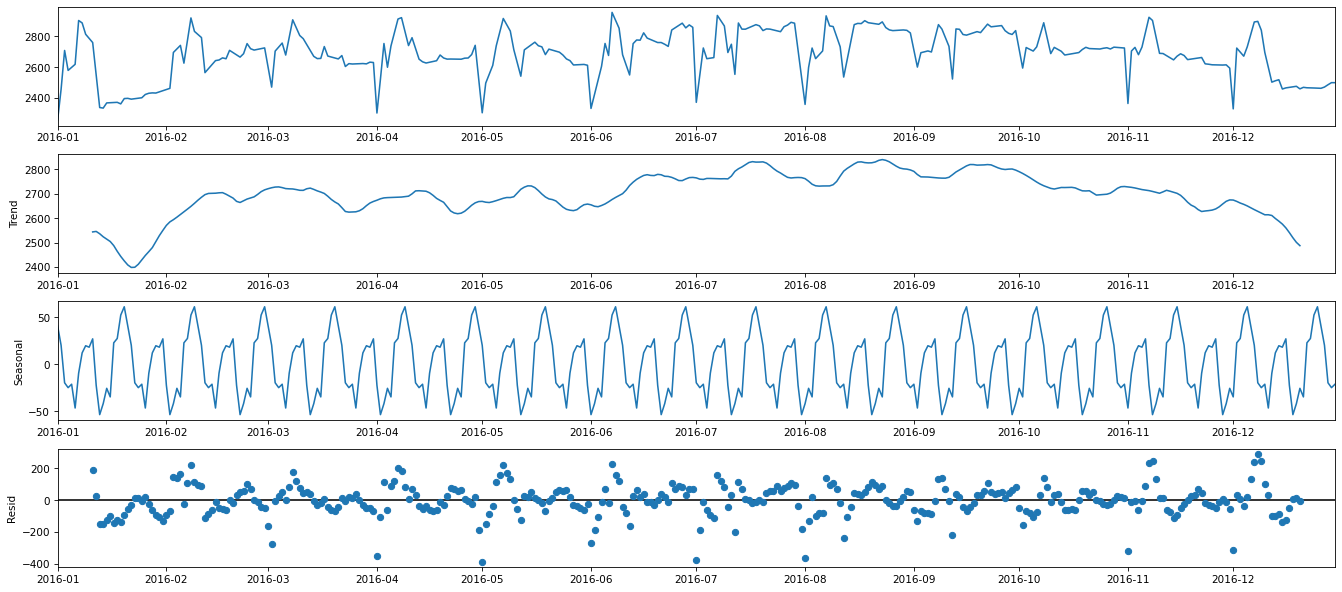

In [24]:
# Seasonal decompose plot for year 2016

plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
result = seasonal_decompose(gold_data_2[:365], model='additive', period=20)
result.plot()
plt.show()

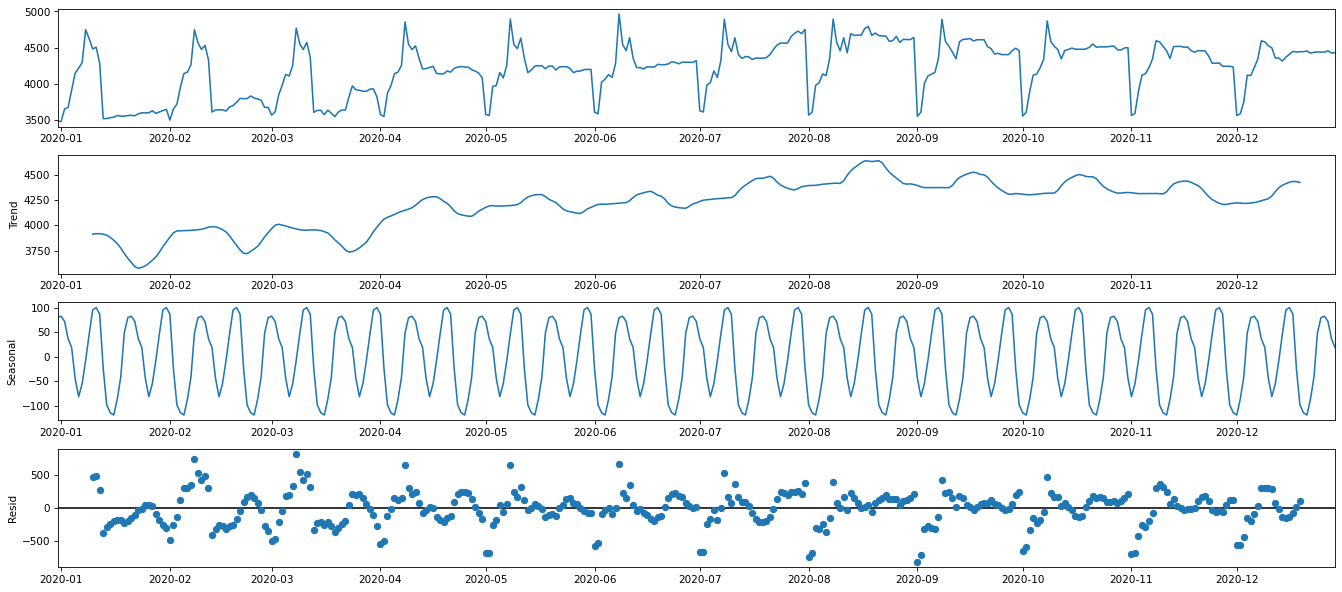

In [25]:
# Seasonal dcompose plot for year 2020

plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
result = seasonal_decompose(gold_data_2[365*4:365*5], model='additive', period=20)
result.plot();

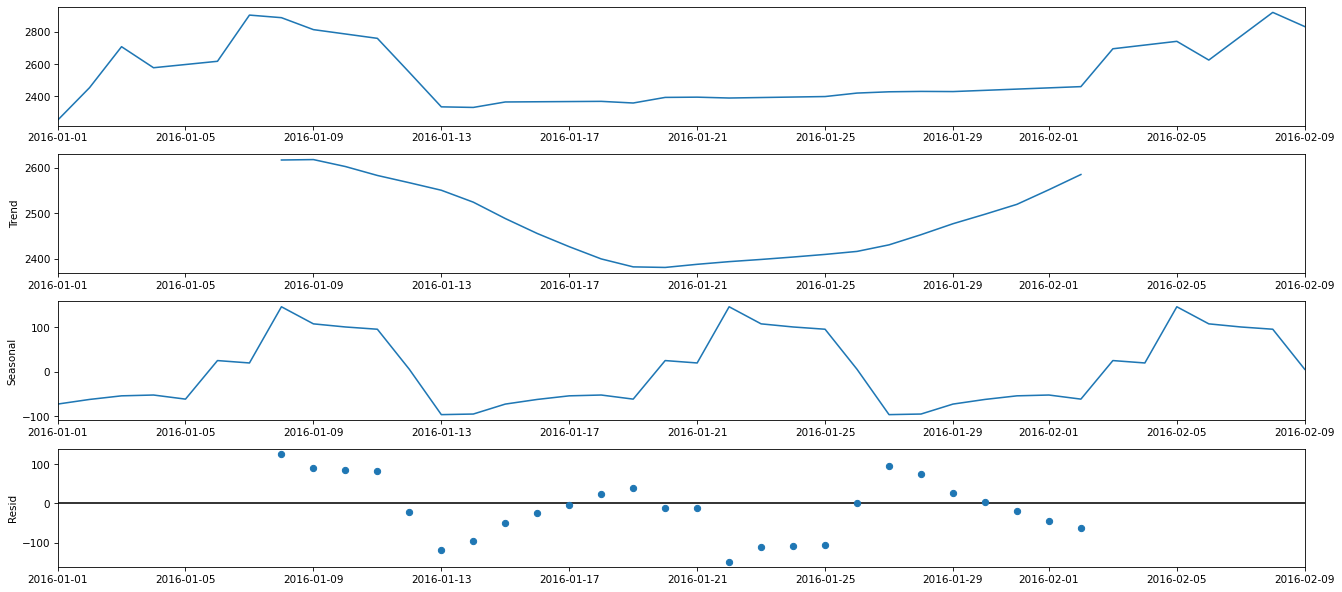

In [26]:
# Seasonality check (weekly) in January 2016

plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
result = seasonal_decompose(gold_data_2[:40], model='additive', period=14)
result.plot();

From the above plots, we can observe that our data follows seasonality:
1. Yearly
2. Monthly
3. Weekly (2 weeks)

#### Check for Stationarity using Augmented Dickey-Fuller (ADF) test

* `H0` : The data is `non-stationary`   ( The data `have` a time dependent structure )
* `H1` : The data is `stationary`   ( The data `does not` have a time dependent structure )

In [27]:
# ADF test to check Stationarity

result = adfuller(gold_data_2, autolag="AIC")

print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.3f}')

for key, value in result[4].items():
    print(f'Critical values({key}): {value:.3f}')
    
if result[0]<result[4]['1%']:
    print("Dataset is stationary!")
    


stat, p, lags, obs, crit, t = adfuller(gold_data_2)
print(f'stat: {stat:.5f}\np-value: {p:.5f}')

if p > 0.05:
    print('Probably not Stationary')
else:
    print('Probably Stationary')

ADF Statistic: -0.310
p-value: 0.924
Critical values(1%): -3.433
Critical values(5%): -2.863
Critical values(10%): -2.567
stat: -0.30990
p-value: 0.92409
Probably not Stationary


In [28]:
# Differencing to make time-series Stationary

gold_data_3 = gold_data_2.diff(1).dropna()

result = adfuller(gold_data_3, autolag="AIC")

print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.3f}')

for key, value in result[4].items():
    print(f'Critical values({key}): {value:.3f}')
    
if result[0]<result[4]['1%']:
    print("Dataset is stationary!")
    


stat, p, lags, obs, crit, t = adfuller(gold_data_3)
print(f'stat: {stat:.5f}\np-value: {p:.5f}')

if p > 0.05:
    print('Probably not Stationary')
else:
    print('Probably Stationary')

ADF Statistic: -21.665
p-value: 0.000
Critical values(1%): -3.433
Critical values(5%): -2.863
Critical values(10%): -2.567
Dataset is stationary!
stat: -21.66454
p-value: 0.00000
Probably Stationary


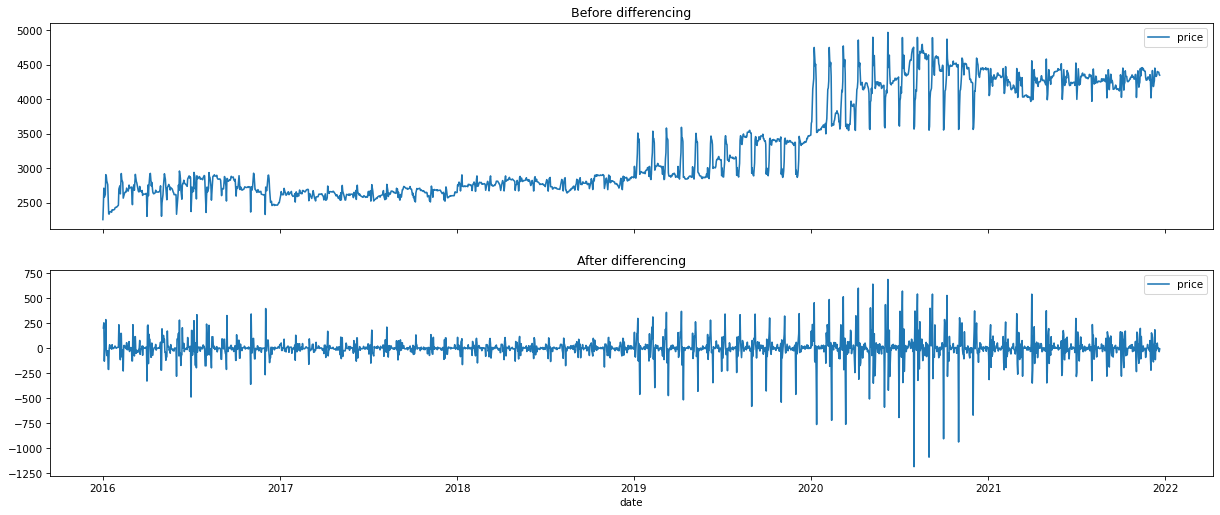

In [29]:
# Lineplot before and after differencing (2016 - 2021)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 8), sharex=True)

sns.lineplot(data=gold_data_2, ax=ax1)
ax1.set_title("Before differencing")
sns.lineplot(data=gold_data_3, ax=ax2)
ax2.set_title("After differencing");

ACF and PACF comparisons

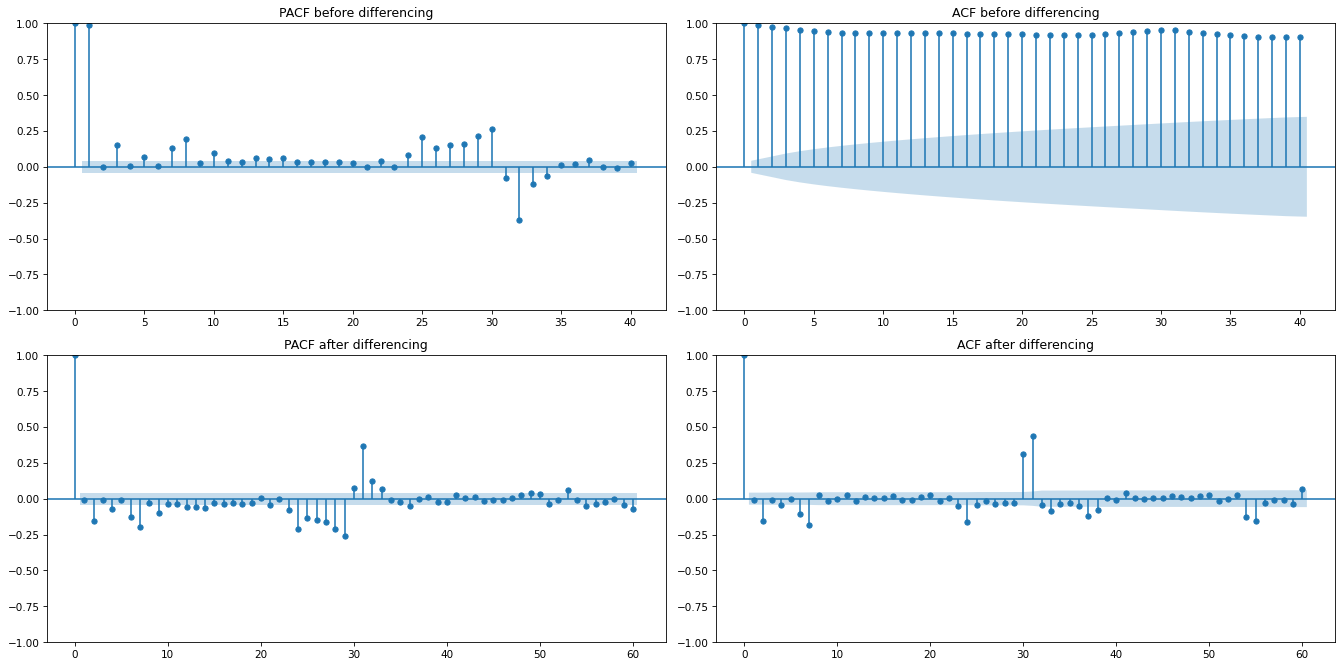

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 9))

plot_pacf(gold_data_2, lags=40, ax=axes[0, 0], method="ols", title="PACF before differencing")
plot_acf(gold_data_2, lags=40, ax=axes[0, 1], title="ACF before differencing")


plot_pacf(gold_data_3, lags=60, ax=axes[1, 0], method="ols", title="PACF after differencing")
plot_acf(gold_data_3, lags=60, ax=axes[1, 1], title="ACF after differencing")

plt.tight_layout();

## 2. Model Building and Experimentations

Splitting the dataset into train and test.
1. We give `80%` of the data to train and rest `20%` to test.
2. We have 2182 rows: 80% of 2182 is 1745.6 ~= 1746.


In [31]:
X_train = gold_data_2[:1746]
X_test = gold_data_2[1746:]

In [32]:
X_train, X_test

(              price
 date               
 2016-01-01  2252.60
 2016-01-02  2454.50
 2016-01-03  2708.10
 2016-01-04  2577.80
 2016-01-05  2597.75
 ...             ...
 2020-10-07  4341.10
 2020-10-08  4869.10
 2020-10-09  4586.40
 2020-10-10  4519.30
 2020-10-11  4473.60
 
 [1746 rows x 1 columns],
              price
 date              
 2020-10-12  4343.3
 2020-10-13  4460.7
 2020-10-14  4473.4
 2020-10-15  4493.3
 2020-10-16  4478.6
 ...            ...
 2021-12-17  4394.4
 2021-12-18  4389.5
 2021-12-19  4389.5
 2021-12-20  4354.1
 2021-12-21  4346.5
 
 [436 rows x 1 columns])

In [33]:
# To calculate MAPE and RMSE

def forecast_accuracy(forecast, actual):
    """
    This functions takes predictions and actual values and give mean absolute percentage error and root mean squared error.
    """
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100
    rmse = np.sqrt(((forecast - actual) ** 2).mean())
    return {'Mean Absolute Percentage Error (%)':mape, 
            'Root Mean Squared Error':rmse}

### 2.1  ARIMA model

In [187]:
# Building auto-arima model
auto_model = pm.auto_arima(X_train.price,
                          d=1,
                          start_p=0,
                          start_q=0,
                          max_p=6,
                          max_q=6,
                          n_jobs=-1)

# Summary of model parameters and the fit
# print(auto_model.summary())

C:\Users\ankit\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [50]:
# Building ARIMA model of best parameters found by auto-arima
model = ARIMA(X_train["price"],
             order=(31,1,31))

# Fitting the model
model_fitted = model.fit();

C:\Users\ankit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ankit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ankit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ankit\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [51]:
# Predicting the data
preds = model_fitted.predict(start=0, end=len(gold_data_2)+1)
preds

2016-01-01       0.000000
2016-01-02    2261.571141
2016-01-03    2490.743126
2016-01-04    2742.206389
2016-01-05    2510.980294
                 ...     
2021-12-19    4431.787887
2021-12-20    4286.626429
2021-12-21    4190.212706
2021-12-22    4249.939939
2021-12-23    4332.304734
Freq: D, Name: predicted_mean, Length: 2184, dtype: float64

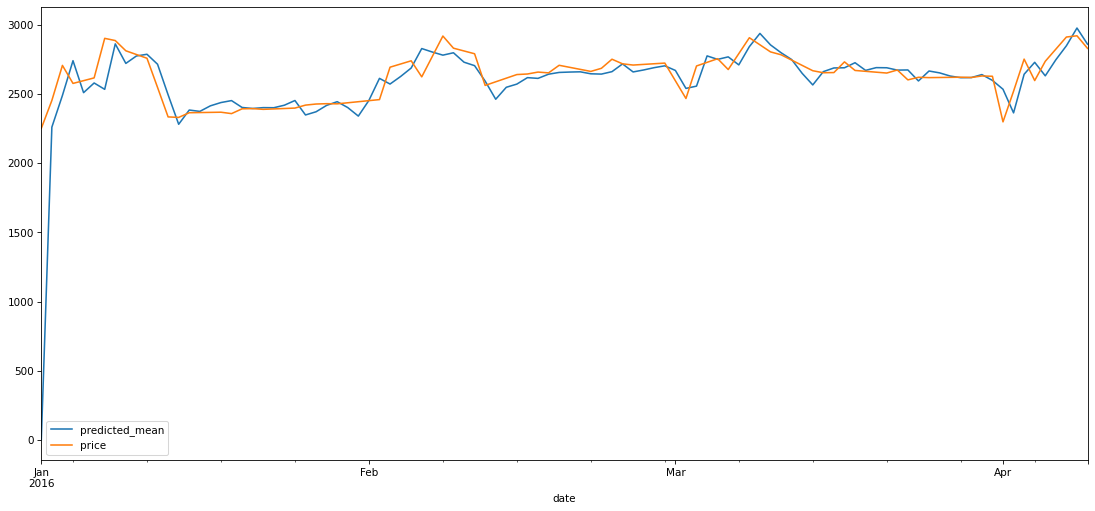

In [52]:
# Plotting train and prediction
preds[:100].plot(legend=True)
gold_data_2["price"][:100].plot(legend=True);

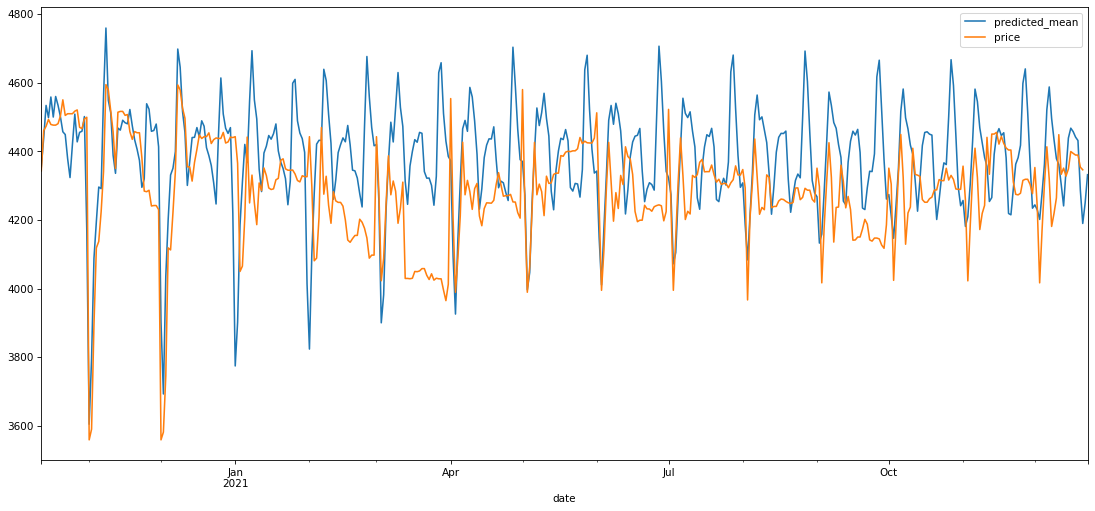

In [53]:
# Plotting test and predictions
preds[1746:].plot(legend=True)
X_test["price"].plot(legend=True);

In [110]:
preds

2020-10-12    4422.824148
2020-10-13    4377.481077
2020-10-14    4347.086595
2020-10-15    4328.434918
2020-10-16    4319.353612
                 ...     
2022-01-16    4364.862992
2022-01-17    4364.862992
2022-01-18    4364.862992
2022-01-19    4364.862992
2022-01-20    4364.862992
Freq: D, Name: predicted_mean, Length: 466, dtype: float64

In [99]:
# Train Accuracy
forecast_accuracy(preds[:1746], X_train["price"])

{'Mean Absolute Percentage Error (%)': 1.8274611372977096,
 'Root Mean Squared Error': 120.02518421414565}

In [100]:
# Test accuracy
forecast_accuracy(preds[1746:], X_test["price"])

{'Mean Absolute Percentage Error (%)': 3.0038502506123255,
 'Root Mean Squared Error': 168.4578425003081}

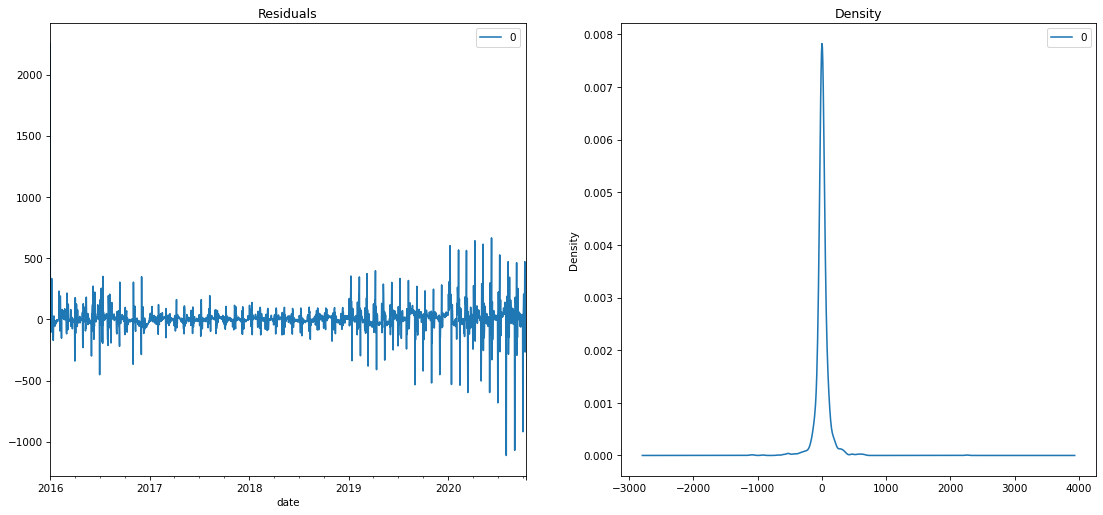

In [42]:
# Residual plot

residuals = pd.DataFrame(model_fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

### 2.2 Holt-Winters

C:\Users\ankit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


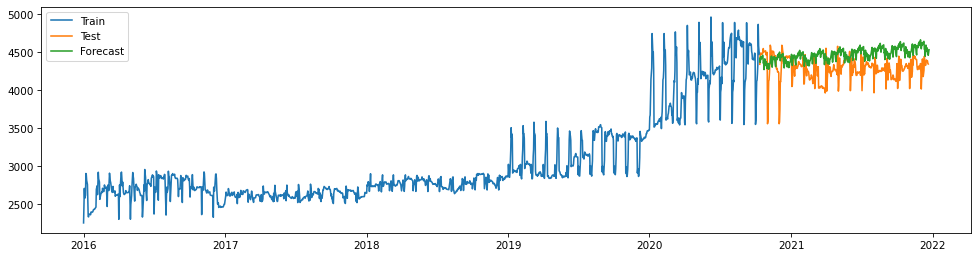

In [45]:
model_hw = ExponentialSmoothing(X_train, trend='add',seasonal_periods=52, seasonal='mul').fit()
forecast_hw = model_hw.predict(start=0, end=len(gold_data_2)+1)

plt.figure(figsize=(16,4))
plt.plot(X_train, label='Train')
plt.plot(X_test, label='Test')
plt.plot(forecast_hw[1746:], label='Forecast')
plt.legend(loc='best');

In [46]:
print(model_hw.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    price   No. Observations:                 1746
Model:             ExponentialSmoothing   SSE                       23796755.369
Optimized:                         True   AIC                          16733.880
Trend:                         Additive   BIC                          17039.925
Seasonal:                Multiplicative   AICC                         16737.937
Seasonal Periods:                    52   Date:                 Sun, 31 Jul 2022
Box-Cox:                          False   Time:                         11:37:50
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9242856                alpha                 True
smoothing_trend          

In [47]:
# Calculating MAPE and RMSE

fc = model_hw.predict(start=0, end=len(gold_data_2)+1)
forecast_accuracy(forecast_hw, gold_data_2["price"])

{'Mean Absolute Percentage Error (%)': 2.5959840390224276,
 'Root Mean Squared Error': 154.67001369393085}

<AxesSubplot:xlabel='date'>

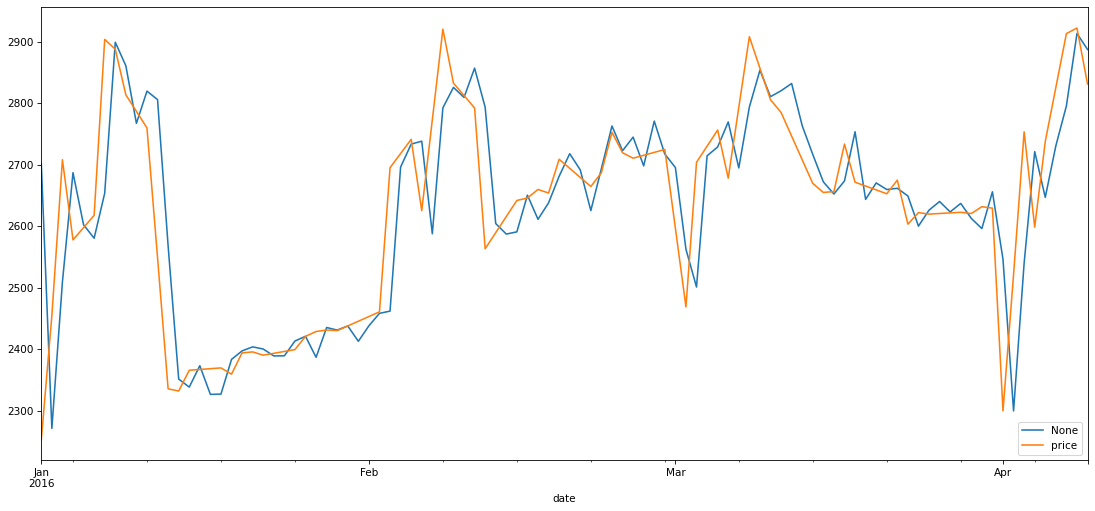

In [48]:
# Train predictions
forecast_hw[:100].plot(legend=True)
gold_data_2["price"][:100].plot(legend=True)

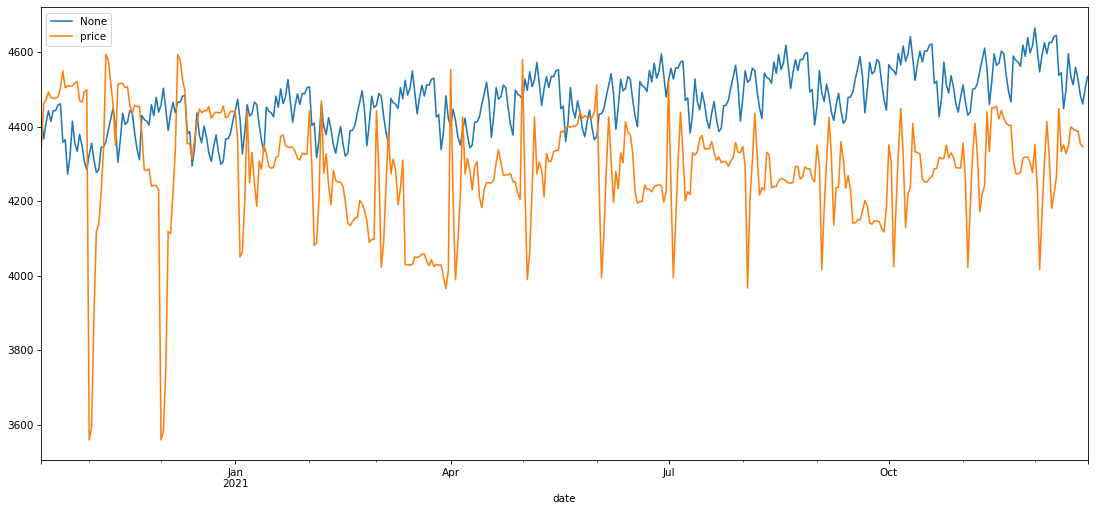

In [49]:
# Test predictions
fc[1746:].plot(legend=True)
X_test["price"].plot(legend=True);

**SARIMAX**

In [186]:
sa_model = SARIMAX(X_train["price"], order=(4,1,2), seasonal_order=(4,0,2,12)).fit();

C:\Users\ankit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ankit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ankit\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ankit\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ankit\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

In [189]:
print(sa_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                 1746
Model:             SARIMAX(4, 1, 2)x(4, 0, 2, 12)   Log Likelihood              -10609.651
Date:                            Mon, 01 Aug 2022   AIC                          21245.301
Time:                                    18:52:04   BIC                          21316.340
Sample:                                01-01-2016   HQIC                         21271.565
                                     - 10-11-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7200      0.209      3.444      0.001       0.310       1.130
ar.L2         -0.0426      0.177   

In [190]:
preds = sa_model.predict(start=0, end=len(gold_data_2)+1)
preds

2016-01-01       0.000000
2016-01-02    2250.522343
2016-01-03    2435.671843
2016-01-04    2653.900571
2016-01-05    2544.100705
                 ...     
2021-12-19    4349.820881
2021-12-20    4380.218802
2021-12-21    4405.426273
2021-12-22    4419.210696
2021-12-23    4456.392057
Freq: D, Name: predicted_mean, Length: 2184, dtype: float64

In [191]:
# Calculating MAPE and RMSE

forecast_accuracy(preds, gold_data_2["price"])

{'Mean Absolute Percentage Error (%)': 2.1735698793018097,
 'Root Mean Squared Error': 135.3216371966715}

In [192]:
print(forecast_accuracy(preds[:1746], X_train["price"]))
print(forecast_accuracy(preds[1746:], X_test["price"]))

{'Mean Absolute Percentage Error (%)': 1.838634766094531, 'Root Mean Squared Error': 118.4462193214203}
{'Mean Absolute Percentage Error (%)': 3.5148467317327743, 'Root Mean Squared Error': 188.3118270201013}


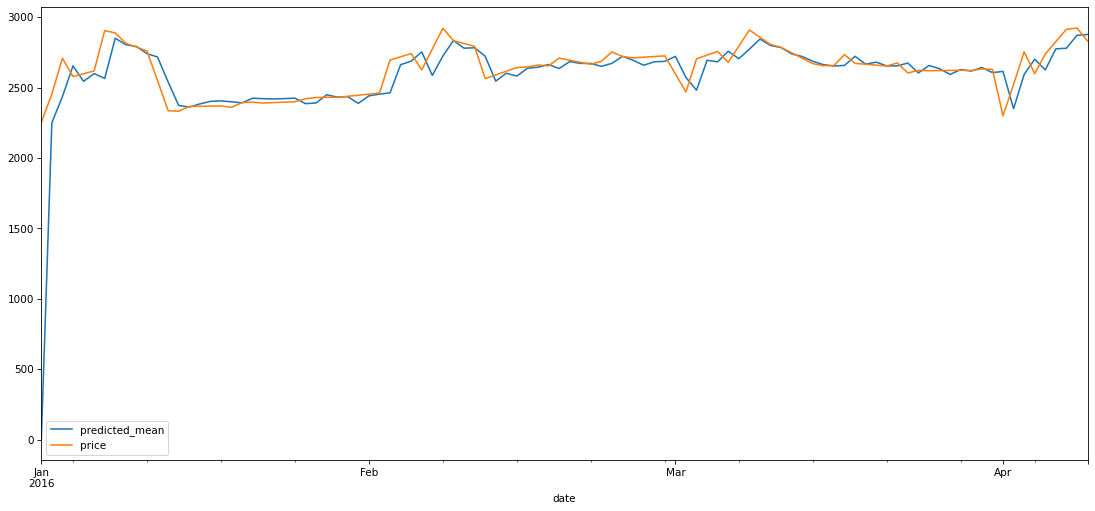

In [193]:
# Plotting train and prediction
preds[:100].plot(legend=True)
gold_data_2["price"][:100].plot(legend=True);

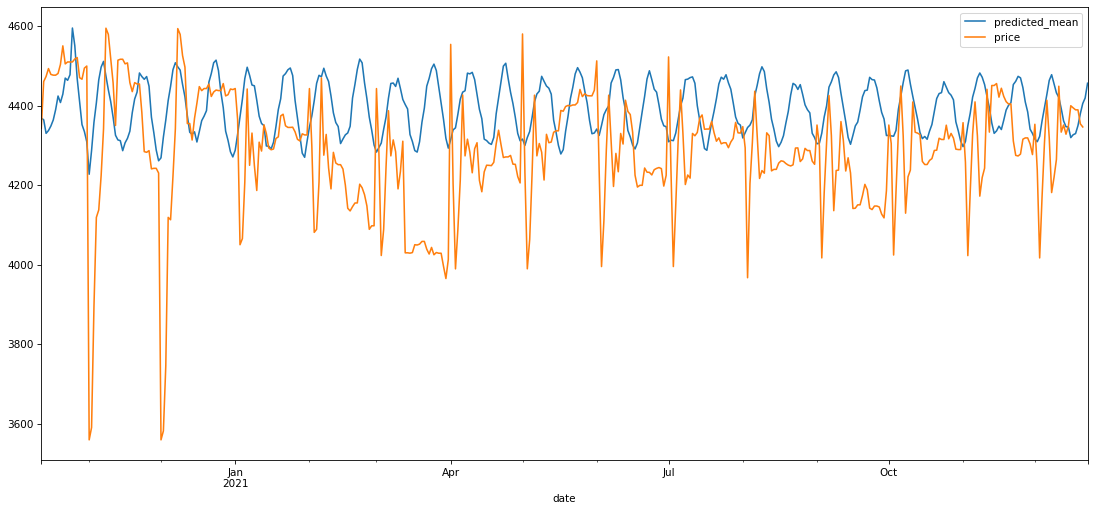

In [194]:
# Plotting test and prediction
preds[1746:].plot(legend=True)
X_test["price"].plot(legend=True);

In [196]:
# Saving SARIMAX model
import pickle
pickle.dump(sa_model, open("sarima-fitted-model.pickle", "wb"))